In [29]:

import random_idx
import utils
import pickle
import re
import string

from pylab import *
from __future__ import division
%matplotlib inline


In [63]:
fdict = open("data/alice-vocabulary.txt")
text = fdict.read()

word_list = text.split('\n')
del word_list[-1] # the last one is just ''
print len(word_list)

2616


In [32]:
def test_word_hit_hypervector(word_list, N=10000):

    hypervector = np.zeros(N)

    letter_vectors = 2 * (np.random.randn(N, len(random_idx.alphabet)) > 0) - 1

    for word in word_list:
        word_vector = np.ones(N)

        for letter in word:
            lidx = random_idx.alphabet.find(letter)

            word_vector = np.roll(word_vector, 1) * letter_vectors[:, lidx]

        hypervector += word_vector

    word_dots = np.zeros(len(word_list))

    for iw,word in enumerate(word_list):
        word_vector = np.ones(N)

        for letter in word:
            lidx = random_idx.alphabet.find(letter)

            word_vector = np.roll(word_vector, 1) * letter_vectors[:, lidx]

        word_dots[iw] = np.dot(hypervector, word_vector)

    return word_dots

In [55]:
N=10000
word_dots = test_word_hit_hypervector(word_list, N=N)

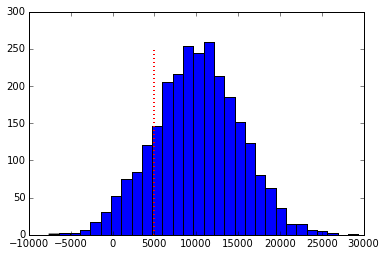

In [56]:
reject_thresh=0.5

hist(word_dots, 30);
plot([N*reject_thresh,N*reject_thresh], [0,250], ':r', lw=2)

In [34]:
import scipy

def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [61]:
print "Simulation: " + str(sum(word_dots > reject_thresh*N) / len(word_dots))
print "Theory:     " + str(p_hit([len(word_list)], N=N, D=1, reject_thresh=reject_thresh)[0])

Simulation: 0.838364539549
Theory:     0.835858300045


In [44]:
test_N = [1e4, 2e4, 4e4, 8e4]

p_hit_N = []
for iN, N in enumerate(test_N):
    print N
    wd = test_word_hit_hypervector(word_list, N=N)
    
    ph = sum(wd > reject_thresh * N) / len(wd)
    
    p_hit_N.append(ph)    


10000.0
20000.0
40000.0
80000.0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [45]:
p_hit_theory = [p_hit([len(word_list)], N=N, D=1, reject_thresh=reject_thresh) for N in test_N]

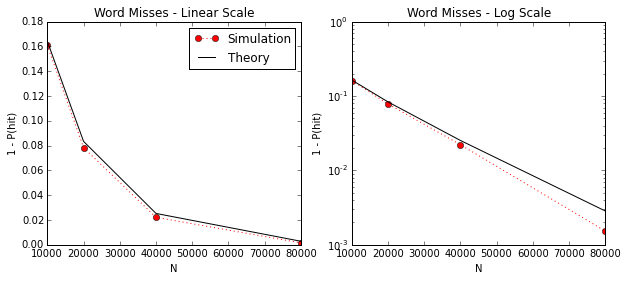

In [60]:
figure(figsize=(10,4))
subplot(121)
plot(test_N, 1-np.array(p_hit_N), ':or', label='Simulation')
plot(test_N, 1-np.array(p_hit_theory), 'k', label='Theory')
title('Word Misses - Linear Scale')
xlabel('N')
ylabel('1 - P(hit)')
legend(loc='upper right')

subplot(122)
plot(test_N, 1-np.array(p_hit_N), ':or', label='Simulation')
plot(test_N, 1-np.array(p_hit_theory), 'k', label='Theory')
yscale('log')

title('Word Misses - Log Scale')
xlabel('N')
ylabel('1 - P(hit)')